In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_percentage_error as mean_ape
from sklearn.metrics import root_mean_squared_error as root_mse

from statsmodels.othermod.betareg import BetaModel

In [2]:
model_data_no_journal = pd.read_parquet("data/model_data_no_journal.parquet")
model_data_no_journal = model_data_no_journal[model_data_no_journal['political_alignment'] != 'autre']
model_data_no_journal['next_pres_votes_share'] = model_data_no_journal['pres_dummy'] * model_data_no_journal['pres_votes_share']

model_data = pd.read_parquet("data/model_data.parquet")
model_data = model_data[model_data['political_alignment'] != 'autre']
model_data['next_pres_votes_share'] = model_data['pres_dummy'] * model_data['pres_votes_share']

In [3]:
nuances_order = ["Far right", "Right", "Center", "Left", "Far left"]

variables_dict = {
    'government': 'Government Participation',
    'leg_votes_share': 'Vote Share in Last Legislative Election',
    'na_share': 'Share of MPs',
    'next_pres_votes_share': 'Vote Share in Next Presidential Election'}

In [4]:
outcome = "quotes_share"

# Beta Regression

No need for zero-inflation as there are no null values in the data.

In [29]:
(model_data_no_journal[outcome] == 0).sum()

np.int64(0)

In [14]:
regressors = ["pres_votes_share", "leg_votes_share", "na_share"]
alignment = 'Far right'

In [15]:
X = model_data_no_journal[model_data_no_journal['political_alignment'] == alignment][regressors]
X = sm.add_constant(X)
y = model_data_no_journal[model_data_no_journal['political_alignment'] == alignment][outcome]

model = BetaModel(endog=y, exog=X)
results = model.fit(cov_type='HC3')

y_pred = results.predict(X)
mape = mean_ape(y, y_pred)
rmspe = root_mse(y, y_pred) / y.mean()

params = results.params.rename("coef").to_frame()
pvalues = results.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

                      coef          pval
const            -3.285858  0.000000e+00
pres_votes_share  0.990096  6.793274e-02
leg_votes_share   5.863645  4.234913e-07
na_share          4.612439  8.771268e-06
precision         3.922005  0.000000e+00

MAPE: 63.05%
RMSPE: 0.60670


In [16]:
model_data_no_journal['y_pred'] = results.predict(sm.add_constant(model_data_no_journal[regressors]))
model_data_no_journal['rel_residuals'] = 100 * (model_data_no_journal[outcome] - model_data_no_journal['y_pred']) / model_data_no_journal[outcome]

In [17]:
summary = []

for alignment in model_data_no_journal['political_alignment'].unique():
    subset_data = model_data_no_journal[model_data_no_journal['political_alignment'] == alignment]
    y = subset_data[outcome]
    y_pred = subset_data['y_pred']
    mape = mean_ape(y, y_pred)
    rmspe = root_mse(y, y_pred) / y.mean()
    summary.append({
        'Political alignment': alignment,
        'MAPE': mape,
        'RMSPE': rmspe
    })

pd.DataFrame(summary).style.hide(axis=0)

Political alignment,MAPE,RMSPE
Center,2.298282,0.866352
Right,0.485266,0.495253
Left,0.386766,0.448322
Far right,0.630520,0.606695
Far left,1.159295,0.867949


In [9]:
plot_data = model_data_no_journal.copy()
plot_data['month'] = plot_data['month'].dt.to_timestamp()

alignment_groups = [
    (['Far left', 'Far right'],
     {'Far left': 'crimson',
      'Far right': 'royalblue'}),
    (['Right', 'Left', 'Center'],
     {'Right': 'cornflowerblue',
      'Left': 'orchid',
      'Center': 'goldenrod'})]

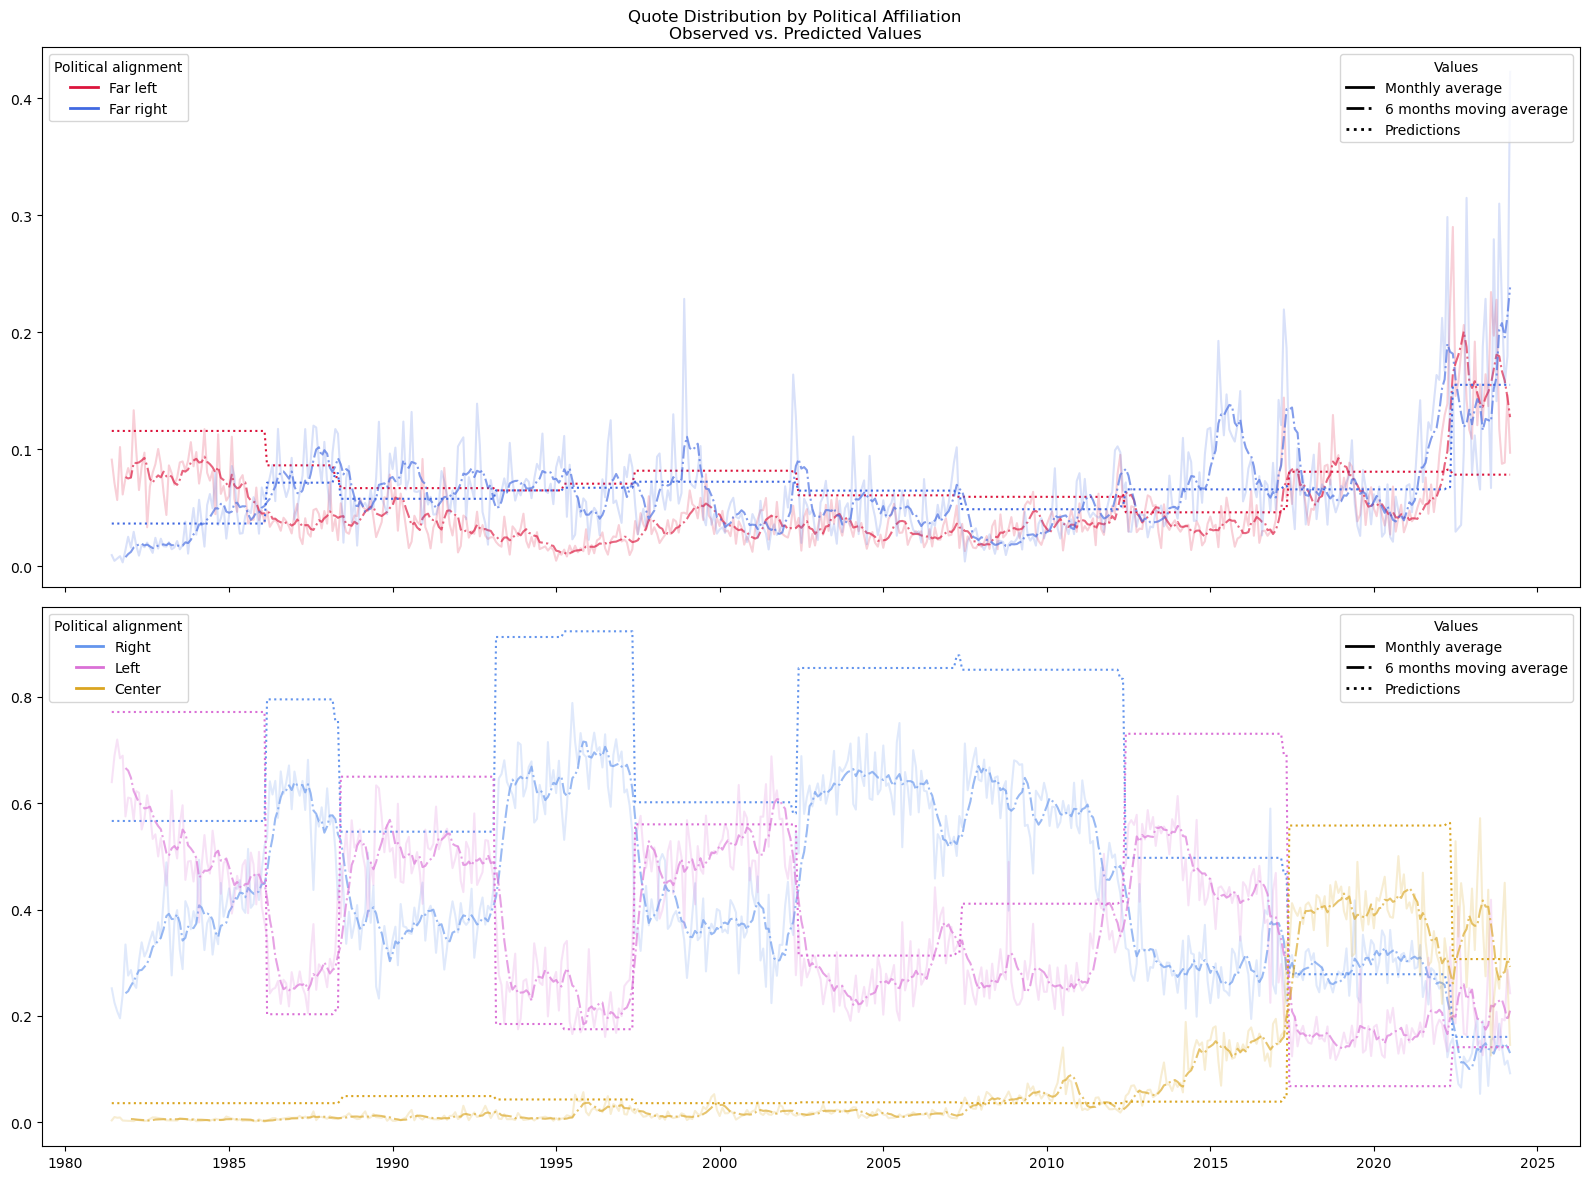

In [10]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

for ax, (political_alignments, colors) in zip(axes, alignment_groups):
    alignment_handles = []

    for alignment in political_alignments:
        subset_data = plot_data[plot_data['political_alignment'] == alignment].copy()
        subset_data['MA'] = subset_data[outcome].rolling(window=6).mean()
        
        ax.plot(subset_data['month'], subset_data[outcome], label=None,
                alpha=0.2, color=colors[alignment], linestyle='-')
        ax.plot(subset_data['month'], subset_data['MA'], label=None,
                alpha=0.65, color=colors[alignment], linestyle='dashdot')
        ax.plot(subset_data['month'], subset_data['y_pred'], label=None,
                alpha=1, color=colors[alignment], linestyle='dotted')
        
        alignment_handles.append(Line2D([0], [0], color=colors[alignment], lw=2, label=alignment))

    alignment_legend = ax.legend(handles=alignment_handles, title="Political alignment", loc="upper left")
    ax.add_artist(alignment_legend)

    line_type_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label="Monthly average"),
        Line2D([0], [0], color='black', lw=2, linestyle='dashdot', label="6 months moving average"),
        Line2D([0], [0], color='black', lw=2, linestyle='dotted', label="Predictions")]
    ax.legend(handles=line_type_handles, title="Values", loc="upper right")

axes[-1].set_xlabel("")

plt.suptitle("Quote Distribution by Political Affiliation\nObserved vs. Predicted Values")
plt.tight_layout()
plt.savefig("output/nuances_val_graph.png", dpi=300, bbox_inches='tight')
plt.show()